# Workbook for MIMIC Hypercapnia Presenting Chief Concern Analysis

This notebook is a deterministic analysis workflow for the NLP-augmented hypercapnia cohort workbook.

## Environment Gate

Fail fast if required packages are missing. Use `uv sync` to repair the environment.

In [1]:
import importlib.util

required_packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "statsmodels",
    "openpyxl",
]
missing = [pkg for pkg in required_packages if importlib.util.find_spec(pkg) is None]
if missing:
    raise ModuleNotFoundError(
        "Missing required packages: "
        + ", ".join(missing)
        + ". Run `uv sync` from the repository root and rerun the notebook."
    )
print("Environment check passed.")


Environment check passed.


## Load Data

Use a single canonical workbook path under `MIMIC tabular data`.

In [2]:
import importlib
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

WORK_DIR = Path(os.getenv("WORK_DIR", Path.cwd())).expanduser().resolve()
SRC_DIR = WORK_DIR / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

analysis_core = importlib.import_module("hypercap_cc_nlp.analysis_core")
binary_crosstab_yes_no = analysis_core.binary_crosstab_yes_no
classify_icd_category_vectorized = analysis_core.classify_icd_category_vectorized
classify_inclusion_type_vectorized = analysis_core.classify_inclusion_type_vectorized
ensure_required_columns = analysis_core.ensure_required_columns
resolve_analysis_paths = analysis_core.resolve_analysis_paths
symptom_distribution_by_overlap = analysis_core.symptom_distribution_by_overlap
to_binary_flag = analysis_core.to_binary_flag

ANALYSIS_INPUT_FILENAME = os.getenv(
    "ANALYSIS_INPUT_FILENAME",
    "2025-10-14 MIMICIV all with CC_with_NLP.xlsx",
)
ANALYSIS_INPUT_PATH = resolve_analysis_paths(WORK_DIR, ANALYSIS_INPUT_FILENAME)
OUTPUT_DIR = WORK_DIR

HYPERCAP_CRITERIA = [
    "any_hypercap_icd",
    "abg_hypercap_threshold",
    "vbg_hypercap_threshold",
    "pco2_threshold_any",
]

SYMPTOM_COL = "RFV1_name"

df = pd.read_excel(ANALYSIS_INPUT_PATH, engine="openpyxl")
ensure_required_columns(df, [SYMPTOM_COL, "any_hypercap_icd", "pco2_threshold_any"])

for column in HYPERCAP_CRITERIA:
    ensure_required_columns(df, [column])
    df[column] = to_binary_flag(df[column])

print(f"Loaded {ANALYSIS_INPUT_PATH.name}: {df.shape[0]:,} rows x {df.shape[1]:,} columns")


Loaded 2025-10-14 MIMICIV all with CC_with_NLP.xlsx: 27,459 rows x 110 columns


## Descriptive Checks

Compute core cohort summaries with guarded column checks.

In [3]:
gender_candidates = [col for col in df.columns if col.lower().startswith("gender")]
if not gender_candidates:
    raise KeyError("No gender-like column found. Expected a column starting with 'gender'.")
gender_col = gender_candidates[0]

gender_summary = (
    df[gender_col]
    .value_counts(dropna=False)
    .rename_axis(gender_col)
    .to_frame("Count")
)
gender_summary["Percent"] = (gender_summary["Count"] / len(df) * 100).round(1)

age_summary = pd.Series(
    {
        "Mean": round(float(df["age"].mean()), 2),
        "SD": round(float(df["age"].std()), 2),
        "Q1": round(float(df["age"].quantile(0.25)), 2),
        "Q3": round(float(df["age"].quantile(0.75)), 2),
    },
    name="Age (years)",
)

hypercap_prevalence = pd.DataFrame(
    {
        "Count": [int(df[col].sum()) for col in HYPERCAP_CRITERIA],
        "Percent": [round(float(df[col].mean() * 100), 1) for col in HYPERCAP_CRITERIA],
    },
    index=HYPERCAP_CRITERIA,
)

display(gender_summary)
display(age_summary.to_frame())
display(hypercap_prevalence)


,Count,Percent
gender,,
M,14522,52.9
F,12937,47.1


,Age (years)
Mean,65.10
SD,17.38
Q1,55.00
Q3,78.00


,Count,Percent
any_hypercap_icd,1983,7.2
abg_hypercap_threshold,16806,61.2
vbg_hypercap_threshold,17422,63.4
pco2_threshold_any,27139,98.8


## ICD And Inclusion Categories

Use vectorized helper functions to avoid row-wise `apply(axis=1)`.

In [4]:
df["icd_category"] = classify_icd_category_vectorized(df)
df["inclusion_type"] = classify_inclusion_type_vectorized(
    df["any_hypercap_icd"],
    df["pco2_threshold_any"],
)

icd_category_summary = (
    df["icd_category"]
    .value_counts(dropna=False)
    .rename_axis("ICD Category")
    .to_frame("Count")
)
icd_category_summary["Percent"] = (icd_category_summary["Count"] / len(df) * 100).round(1)

inclusion_summary = (
    df["inclusion_type"]
    .value_counts(dropna=False)
    .rename_axis("Inclusion Type")
    .to_frame("Count")
)
inclusion_summary["Percent"] = (inclusion_summary["Count"] / len(df) * 100).round(1)

display(icd_category_summary)
display(inclusion_summary)


,Count,Percent
ICD Category,,
Other / None,25476,92.8
Acute RF with hypoxia,793,2.9
Obesity hypoventilation syndrome,524,1.9
Acute RF with hypoxia & hypercapnia,386,1.4
"Respiratory failure, unspecified",187,0.7
Acute RF with hypercapnia,93,0.3


,Count,Percent
Inclusion Type,,
Gas_only,25476,92.8
Both,1663,6.1
ICD_only,320,1.2


In [5]:
symptom_non_null = df.dropna(subset=[SYMPTOM_COL]).copy()
top_symptom_labels = symptom_non_null[SYMPTOM_COL].value_counts().head(10).index
symptom_non_null["symptom_group"] = symptom_non_null[SYMPTOM_COL].where(
    symptom_non_null[SYMPTOM_COL].isin(top_symptom_labels),
    "Other",
)

crosstab_tables = {}
for definition in HYPERCAP_CRITERIA:
    definition_table = binary_crosstab_yes_no(symptom_non_null, "symptom_group", definition)
    crosstab_tables[definition] = definition_table.sort_values("Percent_yes", ascending=False)

display(crosstab_tables["pco2_threshold_any"].head(10))


,No,Yes,Percent_yes
symptom_group,,,
Symptom – Digestive,20,3789,99.5
Diseases (patient-stated),11,1989,99.4
Injuries & adverse effects,12,1961,99.4
Symptom – Nervous,25,3996,99.4
Symptom – Eye/Ear,6,705,99.2
Symptom – Genitourinary,13,1583,99.2
Symptom – General,19,1640,98.9
Symptom – Circulatory,31,2641,98.8
Other,29,2081,98.6


## Symptom Composition By Hypercapnia Definition

Generate counts, percentages, and clipped Wald 95% confidence intervals; export stable tables for downstream reporting.

In [6]:
definition_long_df = symptom_non_null.melt(
    id_vars=["symptom_group"],
    value_vars=HYPERCAP_CRITERIA,
    var_name="Hypercapnia_Definition",
    value_name="Positive",
)
definition_positive_df = definition_long_df.loc[definition_long_df["Positive"].eq(1)].copy()

definition_counts_df = (
    definition_positive_df.groupby(["Hypercapnia_Definition", "symptom_group"], dropna=False)
    .size()
    .reset_index(name="Count")
)
definition_counts_df["Total"] = definition_counts_df.groupby("Hypercapnia_Definition")["Count"].transform("sum")
definition_counts_df["Percent"] = definition_counts_df["Count"] / definition_counts_df["Total"] * 100

p_hat = (definition_counts_df["Percent"] / 100).clip(0, 1)
n_obs = definition_counts_df["Total"].replace(0, np.nan)
se = np.sqrt((p_hat * (1 - p_hat)) / n_obs).fillna(0)
definition_counts_df["CI_lower"] = ((p_hat - 1.96 * se).clip(0, 1) * 100).round(2)
definition_counts_df["CI_upper"] = ((p_hat + 1.96 * se).clip(0, 1) * 100).round(2)
definition_counts_df["Percent"] = definition_counts_df["Percent"].round(2)

definition_counts_df = definition_counts_df.sort_values(
    ["Hypercapnia_Definition", "Count"],
    ascending=[True, False],
)

definition_pivot_df = definition_counts_df.pivot_table(
    index="symptom_group",
    columns="Hypercapnia_Definition",
    values="Percent",
    fill_value=0,
).round(2)

definition_output_path = OUTPUT_DIR / "Symptom_Composition_by_Hypercapnia_Definition.xlsx"
pivot_output_path = OUTPUT_DIR / "Symptom_Composition_Pivot_ChartReady.xlsx"
definition_counts_df.to_excel(definition_output_path, index=False)
definition_pivot_df.to_excel(pivot_output_path)

display(definition_counts_df.head(12))
print(f"Exported: {definition_output_path}")
print(f"Exported: {pivot_output_path}")


,Hypercapnia_Definition,symptom_group,Count,Total,Percent,CI_lower,CI_upper
9,abg_hypercap_threshold,Symptom – Respiratory,3551,16801,21.14,20.52,21.75
8,abg_hypercap_threshold,Symptom – Nervous,2491,16801,14.83,14.29,15.36
4,abg_hypercap_threshold,Symptom – Digestive,2050,16801,12.20,11.71,12.70
3,abg_hypercap_threshold,Symptom – Circulatory,1663,16801,9.90,9.45,10.35
2,abg_hypercap_threshold,Other,1490,16801,8.87,8.44,9.30
1,abg_hypercap_threshold,Injuries & adverse effects,1488,16801,8.86,8.43,9.29
0,abg_hypercap_threshold,Diseases (patient-stated),1387,16801,8.26,7.84,8.67
7,abg_hypercap_threshold,Symptom – Genitourinary,989,16801,5.89,5.53,6.24
6,abg_hypercap_threshold,Symptom – General,938,16801,5.58,5.24,5.93
10,abg_hypercap_threshold,Symptom – Skin/Hair/Nails,449,16801,2.67,2.43,2.92


Exported: /Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/Hypercap-CC-NLP/Symptom_Composition_by_Hypercapnia_Definition.xlsx
Exported: /Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/Hypercap-CC-NLP/Symptom_Composition_Pivot_ChartReady.xlsx


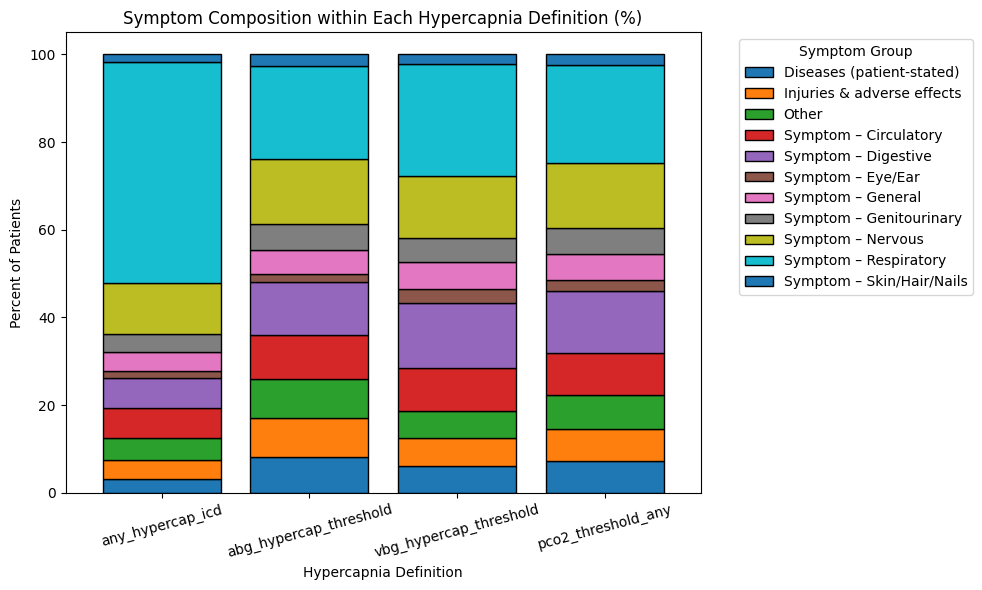

In [7]:
composition_plot_df = definition_pivot_df.T.loc[HYPERCAP_CRITERIA]

ax = composition_plot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    width=0.8,
    edgecolor="black",
)
ax.set_title("Symptom Composition within Each Hypercapnia Definition (%)")
ax.set_xlabel("Hypercapnia Definition")
ax.set_ylabel("Percent of Patients")
ax.tick_params(axis="x", labelrotation=15)
ax.legend(title="Symptom Group", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


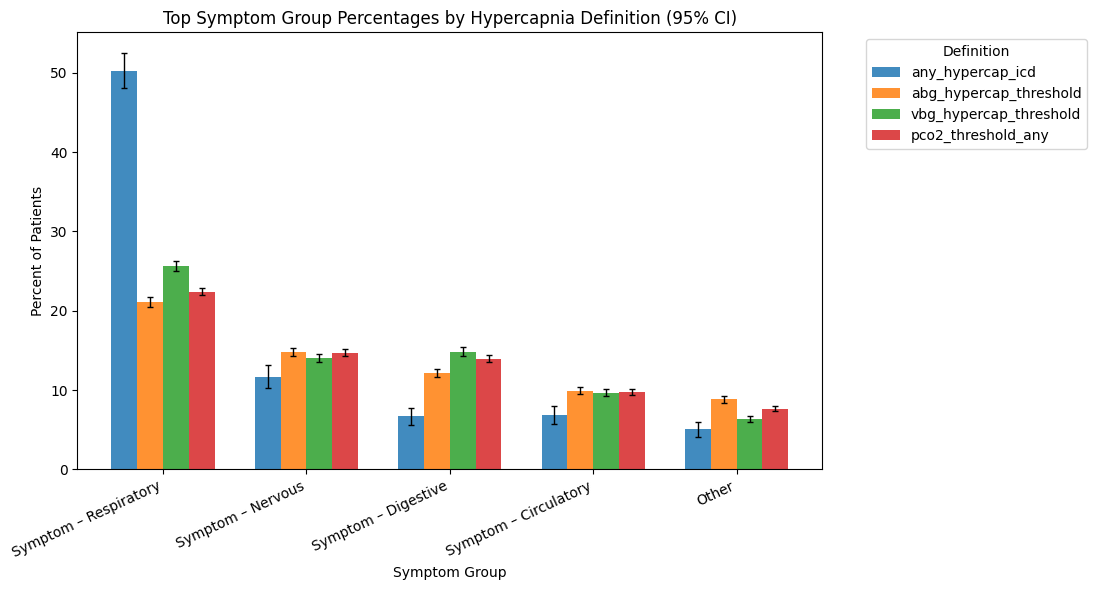

In [8]:
top_for_ci = (
    definition_counts_df.groupby("symptom_group")["Count"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)
ci_plot_df = definition_counts_df.loc[definition_counts_df["symptom_group"].isin(top_for_ci)].copy()
symptom_order = list(top_for_ci)
definition_order = HYPERCAP_CRITERIA

x = np.arange(len(symptom_order))
width = 0.18

fig, ax = plt.subplots(figsize=(11, 6))
for idx, definition in enumerate(definition_order):
    subset = (
        ci_plot_df.loc[ci_plot_df["Hypercapnia_Definition"].eq(definition)]
        .set_index("symptom_group")
        .reindex(symptom_order)
        .fillna(0)
    )
    x_pos = x + (idx - (len(definition_order) - 1) / 2) * width
    y = subset["Percent"].to_numpy()
    lower = subset["CI_lower"].to_numpy()
    upper = subset["CI_upper"].to_numpy()

    ax.bar(x_pos, y, width=width, label=definition, alpha=0.85)
    ax.errorbar(
        x_pos,
        y,
        yerr=[y - lower, upper - y],
        fmt="none",
        ecolor="black",
        elinewidth=1,
        capsize=2,
    )

ax.set_xticks(x)
ax.set_xticklabels(symptom_order, rotation=25, ha="right")
ax.set_ylabel("Percent of Patients")
ax.set_xlabel("Symptom Group")
ax.set_title("Top Symptom Group Percentages by Hypercapnia Definition (95% CI)")
ax.legend(title="Definition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Symptom Distribution By Ascertainment Overlap

In [9]:
overlap_required = [
    SYMPTOM_COL,
    "abg_hypercap_threshold",
    "vbg_hypercap_threshold",
    "any_hypercap_icd",
    "pco2_threshold_any",
]
ensure_required_columns(df, overlap_required)

abg_flag = to_binary_flag(df["abg_hypercap_threshold"])
vbg_flag = to_binary_flag(df["vbg_hypercap_threshold"])
icd_flag = to_binary_flag(df["any_hypercap_icd"])
gas_flag = to_binary_flag(df["pco2_threshold_any"])

abg_vbg_labels = np.select(
    [
        abg_flag.eq(1) & vbg_flag.eq(0),
        abg_flag.eq(0) & vbg_flag.eq(1),
        abg_flag.eq(1) & vbg_flag.eq(1),
    ],
    ["ABG-only", "VBG-only", "ABG+VBG"],
    default="No-gas",
)

icd_gas_labels = np.select(
    [
        icd_flag.eq(1) & gas_flag.eq(1),
        icd_flag.eq(1) & gas_flag.eq(0),
        icd_flag.eq(0) & gas_flag.eq(1),
    ],
    ["ICD+Gas", "ICD-only", "Gas-only"],
    default="Neither",
)

overlap_df = df.copy()
overlap_df["abg_vbg_overlap"] = abg_vbg_labels
overlap_df["icd_gas_overlap"] = icd_gas_labels

gas_positive_df = overlap_df.loc[abg_flag.eq(1) | vbg_flag.eq(1)].copy()
abg_vbg_counts_df, abg_vbg_pivot_df = symptom_distribution_by_overlap(
    gas_positive_df,
    group_col="abg_vbg_overlap",
    symptom_col=SYMPTOM_COL,
    top_k=10,
)
icd_gas_counts_df, icd_gas_pivot_df = symptom_distribution_by_overlap(
    overlap_df,
    group_col="icd_gas_overlap",
    symptom_col=SYMPTOM_COL,
    top_k=10,
)

abg_vbg_output_path = OUTPUT_DIR / "Symptom_Composition_by_ABG_VBG_Overlap.xlsx"
icd_gas_output_path = OUTPUT_DIR / "Symptom_Composition_by_ICD_Gas_Overlap.xlsx"
abg_vbg_pivot_df.to_excel(abg_vbg_output_path)
icd_gas_pivot_df.to_excel(icd_gas_output_path)

print("Symptom distribution by ABG/VBG overlap (gas-positive):")
display(abg_vbg_pivot_df.head(15))
print("Symptom distribution by ICD/Gas overlap:")
display(icd_gas_pivot_df.head(15))
print(f"Exported: {abg_vbg_output_path}")
print(f"Exported: {icd_gas_output_path}")


Symptom distribution by ABG/VBG overlap (gas-positive):


abg_vbg_overlap,ABG+VBG,ABG-only,VBG-only
symptom_group,,,
Diseases (patient-stated),6.5,9.5,5.8
Injuries & adverse effects,8.8,8.9,4.6
Other,7.3,10.0,5.7
Symptom – Circulatory,9.9,9.9,9.5
Symptom – Digestive,12.0,12.4,16.8
Symptom – Eye/Ear,2.2,1.5,3.9
Symptom – General,5.3,5.8,6.8
Symptom – Genitourinary,5.2,6.4,5.8
Symptom – Nervous,13.3,16.0,14.6


Symptom distribution by ICD/Gas overlap:


icd_gas_overlap,Gas-only,ICD+Gas,ICD-only
symptom_group,,,
Diseases (patient-stated),7.6,3.1,3.4
Injuries & adverse effects,7.4,4.4,3.8
Other,7.9,4.3,9.1
Symptom – Circulatory,10.0,6.4,9.7
Symptom – Digestive,14.4,6.8,6.2
Symptom – Eye/Ear,2.7,1.7,1.9
Symptom – General,6.2,3.8,5.9
Symptom – Genitourinary,5.9,4.1,4.1
Symptom – Nervous,14.9,12.4,7.8


Exported: /Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/Hypercap-CC-NLP/Symptom_Composition_by_ABG_VBG_Overlap.xlsx
Exported: /Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/Hypercap-CC-NLP/Symptom_Composition_by_ICD_Gas_Overlap.xlsx


## Association Model

Logistic regression of respiratory symptom flag on hypercapnia definitions.

In [10]:
model_df = df.dropna(subset=[SYMPTOM_COL]).copy()
model_df["is_respiratory"] = model_df[SYMPTOM_COL].astype(str).str.contains(
    r"\brespir", case=False, na=False
).astype(int)

design_matrix = sm.add_constant(model_df[HYPERCAP_CRITERIA], has_constant="add")
outcome = model_df["is_respiratory"]
logit_result = sm.Logit(outcome, design_matrix, missing="drop").fit(disp=False)

or_table = pd.DataFrame(
    {
        "OR": np.exp(logit_result.params),
        "CI_lo": np.exp(logit_result.conf_int()[0]),
        "CI_hi": np.exp(logit_result.conf_int()[1]),
        "p": logit_result.pvalues,
    }
).round(3)

display(or_table.loc[HYPERCAP_CRITERIA])


,OR,CI_lo,CI_hi,p
any_hypercap_icd,3.684,3.322,4.085,0.000
abg_hypercap_threshold,1.002,0.933,1.076,0.948
vbg_hypercap_threshold,1.547,1.432,1.672,0.000
pco2_threshold_any,0.895,0.688,1.164,0.409


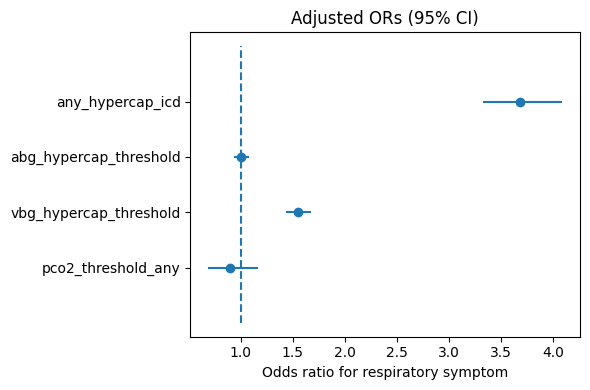

In [11]:
or_plot_df = or_table.loc[HYPERCAP_CRITERIA]
y_positions = np.arange(len(or_plot_df))[::-1]

plt.figure(figsize=(6, 4))
plt.hlines(y=y_positions, xmin=or_plot_df["CI_lo"], xmax=or_plot_df["CI_hi"], linewidth=1.5)
plt.plot(or_plot_df["OR"], y_positions, "o")
plt.vlines(1, ymin=-1, ymax=len(or_plot_df), linestyles="dashed")
plt.yticks(y_positions, or_plot_df.index)
plt.xlabel("Odds ratio for respiratory symptom")
plt.title("Adjusted ORs (95% CI)")
plt.tight_layout()
plt.show()


## Export Verification

In [12]:
expected_outputs = [
    definition_output_path,
    pivot_output_path,
    abg_vbg_output_path,
    icd_gas_output_path,
]

verification_rows = []
for output_path in expected_outputs:
    verification_rows.append(
        {
            "path": str(output_path),
            "exists": output_path.exists(),
            "size_bytes": output_path.stat().st_size if output_path.exists() else 0,
        }
    )

output_verification = pd.DataFrame(verification_rows)
display(output_verification)


,path,exists,size_bytes
0,/Users/blocke/Box Sync/Residency Personal File...,True,6914
1,/Users/blocke/Box Sync/Residency Personal File...,True,5470
2,/Users/blocke/Box Sync/Residency Personal File...,True,5365
3,/Users/blocke/Box Sync/Residency Personal File...,True,5364
